In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
!pip install catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

     |████████████████████████████████| 66.2MB 47kB/s 


In [ ]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data
 
def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata
 
def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata
 
def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, -999, traindata[_])
        
    return traindata
 
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data
 
 
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a
 
def make_submission(prediction, filename):
 
  path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'
 
  test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
  #test_prediction = model.predict(testdata)
 
  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')
 
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [ ]:
A = np.load('/content/drive/My Drive/FORCE-Lithology-Prediction/penalty_matrix.npy')
 
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]
 
def evaluate(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(24,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [ ]:
#importing miles
train = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/train1.csv')
test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
valid1 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid4.csv')
valid2 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid5.csv')
valid3 = pd.concat((valid1, valid2)).reset_index(drop=True)

In [ ]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid3_lithology = valid3['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid3_lithology = valid3_lithology.map(lithology_numbers)

In [ ]:
train_well = train.WELL.values
train_depth = train.DEPTH_MD.values
 
valid1_well = valid1.WELL.values
valid1_depth = valid1.DEPTH_MD.values
 
valid2_well = valid2.WELL.values
valid2_depth = valid2.DEPTH_MD.values
 
valid3_well = valid3.WELL.values
valid3_depth = valid3.DEPTH_MD.values

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
nvalid1 = valid1.shape[0]
nvalid2 = valid2.shape[0]
nvalid3 = valid3.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test, valid1, valid2, valid3)).reset_index(drop=True)

In [ ]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid3_lithology = valid3['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 0,
                 65000: 0,
                 80000: 0,
                 74000: 0,
                 70000: 0,
                 70032: 0,
                 88000: 0,
                 86000: 0,
                 99000: 0,
                 90000: 0,
                 93000: 1}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid3_lithology = valid3_lithology.map(lithology_numbers)

In [ ]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA']
df = drop_columns(df, *cols)
print(df.shape)

(1512843, 29)
(1512843, 24)


In [ ]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes

In [ ]:
df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
df.shape
 
df = df.fillna(-999)
df = process(df)
data = df.copy()
 
train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation1_target = valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation2_target = valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
 
test2 = data[ntrain:(ntest+ntrain)].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)
 
validation1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
validation1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation1 = validation1.reset_index(drop=True)
 
validation2 = data[(ntrain+ntest+nvalid1): (ntrain+ntest+nvalid1+nvalid2)].copy()
validation2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation2 = validation2.reset_index(drop=True)
 
 
validation3 = data[(ntrain+ntest+nvalid1+nvalid2):].copy()
validation3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation3 = validation3.reset_index(drop=True)
 
print(train2.shape, test2.shape, validation1.shape, valid1.shape, validation2.shape, validation3.shape, valid2.shape)

(964965, 23) (136786, 23) (114079, 23) (114079, 29) (91467, 23) (205546, 23) (91467, 29)


In [ ]:
traindata = train2
testdata = test2
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler().fit(traindata)
def scale_data(data):
  
  data = scaler.transform(data)
  #testdata = scaler.transform(testdata)
  data = pd.DataFrame(data, columns=testdata.columns)
 
  return data

In [ ]:
#traindata, padded_rows = augment_features(traindata.values, train_well, train_depth)
#validation1, padded_rows1 = augment_features(validation1.values, valid1_well, valid1_depth)
#validation2, padded_rows2 = augment_features(validation2.values, valid2_well, valid2_depth)
#validation3, padded_rows3 = augment_features(validation3.values, valid3_well, valid3_depth)
 
#traindata.shape, validation1.shape, validation3.shape, validation2.shape

In [ ]:
validation, traindata, valid_target, lithology = ms.train_test_split(pd.DataFrame(traindata), lithology, random_state=405, test_size=0.9, stratify=lithology)
print(validation.shape, valid_target.shape, traindata.shape, lithology.shape)

(96496, 23) (96496,) (868469, 23) (868469,)


In [ ]:
def sort_data(data):
    a = data.sort_index(inplace=False)
    return a
 
validation=sort_data(pd.DataFrame(validation))
traindata=sort_data(pd.DataFrame(traindata))
#validation.head(3)

In [ ]:
valid_target = sort_data(pd.DataFrame(valid_target))
lithology = sort_data(pd.DataFrame(lithology))

In [ ]:
class Model():
    
    def __init__(self, train, test, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 5
      kf = StratifiedKFold(n_splits=split, shuffle=False)
  
      pred = np.zeros((len(self.test), 2))
      val1 = np.zeros((len(self.validation1), 2))
      val2 = np.zeros((len(self.validation2), 2))
      val3 = np.zeros((len(self.validation3), 2))
 
      #model = CatBoostClassifier(n_estimators=500000, random_state=2020, learning_rate=0.033,
                                 #use_best_model=True, max_depth=8, reg_lambda=1500,
                                 #eval_metric='MultiClass', task_type='GPU', verbose=100)
 
      model = XGBClassifier(n_estimators=1000, max_depth=10, reg_lambda=500,
                            objective='binary:logistic', learning_rate=0.1, random_state=250,
                            subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='logloss', verbose=2020)
      
      #model = LGBMClassifier(n_estimators=50000, max_depth=10, reg_lambda=1200,
                            #objective='multiclass', learning_rate=0.033,
                            #eval_metric='multi_logloss', subsample=0.9, col_sample_bytree=0.9)
      
      #model = RandomForestClassifier(n_estimators=2, class_weight='balanced')
      #model = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=50, eval_set=[(X_test, Y_test)], verbose=20)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(pd.DataFrame(self.validation1))
        prediction = model.predict(pd.DataFrame(self.validation2))
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        pred += model.predict_proba(pd.DataFrame(self.test))
        val1 += model.predict_proba(pd.DataFrame(self.validation1))
        val2 += model.predict_proba(pd.DataFrame(self.validation2))
        val3 += model.predict_proba(pd.DataFrame(self.validation3))
      
      pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)

      pred = np.array(pred)
      val1 = np.array(val1)
      val2 = np.array(val2)
      val3 = np.array(val3)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      #val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      #val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      #val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      pred11 = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val11 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val22 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val33 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val11, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val22, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val33, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return pred[:,1], val1[:,1], val2[:,1], val3[:,1], model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
#func1_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred1, val1, open_test1, open_test1a, model1 = func1_()

In [ ]:
#func2_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred2, val2, open_test2, open_test22, model2 = func2_()

In [ ]:
#func3_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred3, val3, open_test3, open_test33, model3 = func3_()

In [ ]:
#func4_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred4, val4, open_test4, open_test44, model4 = func4_()

In [ ]:
#func5_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred5, val5, open_test5, open_test55, model5 = func5_()

In [ ]:
#func6_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred6, val6, open_test6, open_test66, model6 = func6_()

In [ ]:
#func7_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred7, val7, open_test7, open_test77, model7 = func7_()

In [ ]:
#func8_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred8, val8, open_test8, open_test88, model8 = func8_()

In [ ]:
#func9_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred9, val9, open_test9, open_test99, model9 = func9_()

In [ ]:
#func10_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred10, val10, open_test10, open_test110, model10 = func10_()

In [ ]:
#func11_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred11, val11, open_test11, open_test111, model11 = func11_()

In [ ]:
#func12_= Model(traindata, validation, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#pred12, val12, open_test12, open_test112, model12 = func12_()

In [ ]:
stack = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10, pred11, pred12))
stack_p = np.column_stack((val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12))
stack_open = np.column_stack((open_test1, open_test2, open_test3, open_test4, open_test5, open_test6, open_test7, open_test8, open_test9, open_test10, open_test11, open_test12))
stack_open1 = np.column_stack((open_test1a, open_test22, open_test33, open_test44, open_test55, open_test66, open_test77, open_test88, open_test99, open_test110, open_test111, open_test112))

In [ ]:
pd.DataFrame(stack_p).tail(50)

,0,1,2,3,4,5,6,7,8,9,10,11
114029,0.374518,0.465062,0.405746,0.151928,0.092162,0.156459,0.091079,0.001540,0.090212,0.002093,0.005089,0.066109
114030,0.388508,0.465062,0.392066,0.151928,0.092162,0.160020,0.091079,0.001540,0.090211,0.002094,0.005466,0.066117
114031,0.405816,0.465062,0.351830,0.151928,0.092032,0.162112,0.091079,0.001540,0.090225,0.002093,0.005339,0.066118
114032,0.537770,0.459445,0.329910,0.151928,0.092050,0.172630,0.091080,0.001540,0.090229,0.002101,0.005694,0.066118
114033,0.687965,0.453513,0.262351,0.151928,0.092204,0.174366,0.091080,0.001540,0.090232,0.002101,0.005809,0.066118
114034,0.703408,0.453513,0.260091,0.151928,0.092402,0.179080,0.091183,0.001540,0.090241,0.002103,0.005768,0.066118
114035,0.714621,0.453513,0.258536,0.151928,0.092624,0.209170,0.091294,0.001540,0.090256,0.002105,0.005918,0.066118
114036,0.721492,0.453513,0.257109,0.151928,0.092839,0.233774,0.091388,0.001540,0.090262,0.002106,0.005733,0.066118
114037,0.717253,0.453513,0.258516,0.151928,0.093353,0.209170,0.091295,0.001540,0.090246,0.002106,0.005678,0.066118
114038,0.708699,0.453513,0.260067,0.151928,0.091993,0.176170,0.091184,0.001540,0.090224,0.002104,0.005549,0.066118


In [ ]:
valid1_lithology.tail(50)

114029    2
114030    2
114031    2
114032    2
114033    2
114034    2
114035    2
114036    2
114037    2
114038    2
114039    2
114040    2
114041    2
114042    2
114043    2
114044    2
114045    2
114046    2
114047    2
114048    2
114049    2
114050    2
114051    2
114052    2
114053    2
114054    2
114055    2
114056    2
114057    2
114058    2
114059    2
114060    2
114061    2
114062    2
114063    2
114064    2
114065    2
114066    2
114067    2
114068    2
114069    2
114070    2
114071    2
114072    2
114073    2
114074    2
114075    2
114076    2
114077    2
114078    2
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [ ]:
 stack = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8))
stack_p = np.column_stack((val1, val2, val3, val4, val5, val6, val7, val8))
stack_open = np.column_stack((open_test1, open_test2, open_test3, open_test4, open_test5, open_test6, open_test7, open_test8))
stack_open1 = np.column_stack((open_test11, open_test22, open_test33, open_test44, open_test55, open_test66, open_test77, open_test88))

In [ ]:
np.unique(open_test7, return_counts=True)

(array([0]), array([91467]))

In [ ]:
meta_model = LogisticRegression()
#meta_model = RandomForestClassifier(n_estimators=100, random_state=890, verbose=2, class_weight='balanced')
#meta_model = ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
meta_model.fit(stack, valid_target)
final_val_pred = meta_model.predict(stack_p)
final_open_pred = meta_model.predict(stack_p)
final_open_pred1 = meta_model.predict(stack_open)
final_open_pred11 = meta_model.predict(stack_open1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
final_open_pred = pd.DataFrame(final_open_pred)
final_open_pred1 = pd.DataFrame(final_open_pred1)
final_open_pred11 = pd.DataFrame(final_open_pred11)
    
final_open_pred = np.array(pd.DataFrame(final_open_pred).idxmax(axis=1))
final_open_pred1 = np.array(pd.DataFrame(final_open_pred1).idxmax(axis=1))
final_open_pred11 = np.array(pd.DataFrame(final_open_pred11).idxmax(axis=1))

LOGISTIC REGRESSION META STACKER RESULT

In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.8393591283233549
Accuracy is: 0.7080005960781564
F1 is: 0.7851857424717705
None
Default score: -0.6946057047897056
Accuracy is: 0.7555949140127041
F1 is: 0.8240832920449708
None
Default score: -0.7749445379623052
Accuracy is: 0.7291798429548617
F1 is: 0.8019078017608368
None


In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.8129443192875113
Accuracy is: 0.7139789093522909
F1 is: 0.7741328642741403
None
Default score: -0.6669850875179026
Accuracy is: 0.761848535537407
F1 is: 0.8246254310271689
None
Default score: -0.7479931499518356
Accuracy is: 0.7352806671012815
F1 is: 0.7948853606804036
None


In [ ]:
stack_p.shape

(114079, 48)

In [ ]:
class Model():
    
    def __init__(self, train, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        #self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      #self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                  # pd.DataFrame(np.array(self.train_label)), 
                                                                                   #test_size=0.2,
                                                                                   #random_state=212)
      #self.x_train = self.train.iloc[:700000]
      #self.x_test = self.train.iloc[700000:]
      #self.y_train = pd.DataFrame(self.train_label).iloc[:700000]
      #self.y_test = pd.DataFrame(self.train_label).iloc[700000:]
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
      split = 5
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      #pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      #model = CatBoostClassifier(n_estimators=5000, random_state=2020, learning_rate=0.033,
                                 #use_best_model=True, max_depth=10, reg_lambda=1500,
                                 #eval_metric='MultiClass', task_type='GPU', verbose=100)
 
      model = XGBClassifier(n_estimators=100, max_depth=10, reg_lambda=1200, booster_type='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=2020,
                            subsample=0.7, col_sample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020)
      
      #model = LGBMClassifier(n_estimators=50000, max_depth=10, reg_lambda=200,
                            #objective='multiclass', learning_rate=0.033,
                            #eval_metric='multi_logloss')
      
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(pd.DataFrame(self.validation1))
        prediction = model.predict(pd.DataFrame(self.validation2))
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.test)
        val1 += model.predict_proba(pd.DataFrame(self.validation1))
        val2 += model.predict_proba(pd.DataFrame(self.validation2))
        val3 += model.predict_proba(pd.DataFrame(self.validation3))
      
      #pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val1, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val2, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val3, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.37987
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.528698
[200]	validation_0-mlogloss:0.36638
[299]	validation_0-mlogloss:0.311491
Default score: -0.6154145372943312
Accuracy is: 0.7688268655931416
F1 is: 0.8040155873188836
None
Default score: -0.5592987088239474
Accuracy is: 0.7917281642559612
F1 is: 0.8185497760510676
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.37999
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.525108
[200]	validation_0-mlogloss:0.362007
[299]	validation_0-mlogloss:0.307947
Default score: -0.6165979277518211
Accuracy is: 0.7687041436197722
F1 is: 0.8036775928572035
None
Default score: -0.5567199099128648
Accuracy is: 0.7928105218275444
F1 is: 0.8191677659718717
None
-----------------------FOLD 2---------------------
[0]	validation_0-mlogloss:2.37978
Will train until validation_0-mlogloss hasn

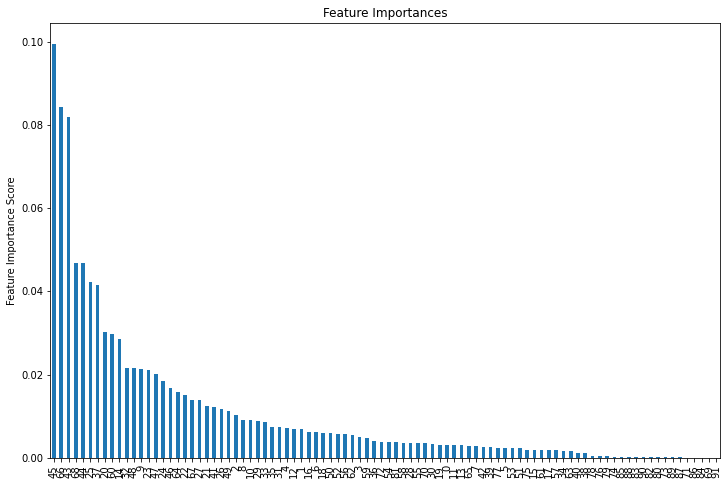

In [ ]:
func1_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val1, open_test1, open_test11, model1 = func1_()   #no reglambda, 0.01 lr, 10max-depth

In [ ]:
pred1

array([2, 2, 2, ..., 1, 0, 0])

In [ ]:
final_val = np.array(pd.DataFrame(val).idxmax(axis=1))
final_open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
final_open_test_b = np.array(pd.DataFrame(open_testa).idxmax(axis=1))

In [ ]:
print(show_evaluation(val1, valid1_lithology))
print(show_evaluation(open_test1, valid2_lithology))
print(show_evaluation(open_test11, valid3_lithology))

Default score: -0.617504098037325
Accuracy is: 0.7683359776996642
F1 is: 0.8038841337036852
None
Default score: -0.5671663004143571
Accuracy is: 0.7890605354936753
F1 is: 0.8165453402739566
None
Default score: -0.5951040156461327
Accuracy is: 0.7775583081159448
F1 is: 0.8089888016227615
None


In [ ]:
 print(show_evaluation(val2, valid1_lithology))
print(show_evaluation(open_test2, valid2_lithology))
print(show_evaluation(open_test22, valid3_lithology))

Default score: -0.6234298161800156
Accuracy is: 0.7660217919161283
F1 is: 0.7986957722089358
None
Default score: -0.5648157258902118
Accuracy is: 0.7891917303508369
F1 is: 0.8158804624594801
None
Default score: -0.597346822609051
Accuracy is: 0.7763323051774299
F1 is: 0.8058267796854165
None
